In [1]:
# Real Time Machine Learning 
# HW2
# Shanle Yao
# 800962310

## Q1.1

In [2]:
import pandas as pd 
%matplotlib inline
import numpy as np
import torch
from torchvision import transforms
from torchvision import datasets
import torch.optim as optim
import matplotlib.pyplot as plt  


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
print()
if device.type == 'cuda':
    print(torch.cuda.get_device_name())
    print("Memory Usage:")
    print("\tAllocated:", round(torch.cuda.memory_allocated()/1024**3,1), "GB")
    print("\tCached:", round(torch.cuda.memory_reserved()/1024**3,1), "GB")
#device = torch.device('cpu')

Using device:  cuda

NVIDIA GeForce RTX 3070 Ti
Memory Usage:
	Allocated: 0.0 GB
	Cached: 0.0 GB


In [4]:
housing = pd.DataFrame(pd.read_csv(r"C:\Users\Anaconda\UNCC\UNCC\ECGR5106\HW1\Housing.csv")) 
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price'] 
housing = housing[num_vars] 

In [5]:
split = int(len(housing)*0.8)

t_train_u = housing.iloc[:split,:5]
t_train_x = housing.iloc[:split,5]
t_train_u = torch.from_numpy(t_train_u.to_numpy())
t_train_x = torch.from_numpy(t_train_x.to_numpy())
t_train_u = t_train_u.float()
t_train_x = t_train_x.float()

t_val_u = housing.iloc[:split,:5]
t_val_x = housing.iloc[:split,5]
t_val_u = torch.from_numpy(t_val_u.to_numpy())
t_val_x = torch.from_numpy(t_val_x.to_numpy())
t_val_u = t_val_u.float()
t_val_x = t_val_x.float()

In [6]:
# Normalizing
t_train_un = t_train_u
for i in range(5):
    t_train_un[:,i] = t_train_u[:,i]/t_train_u[:,i].max()
t_train_xn = t_train_x/t_train_x.max()

t_val_un = t_val_u
for i in range(5):
    t_val_un[:,i] = t_val_u[:,i]/t_val_u[:,i].max()


t_val_xn = t_val_x/t_val_x.max()

In [7]:
import torch.nn as nn
model = nn.Sequential(
    nn.Linear(5,8),
    nn.Tanh(),
    nn.Linear(8,1)
)

optimizer = optim.SGD(
    model.parameters(),
    lr=1e-2
)

In [8]:
import time

def training_loop(n_epochs, optimizer, model, loss_fn, t_train_u, t_train_x, t_val_u, t_val_x):
    second = time.time()
    t = []
    val = []
    for epoch in range(1, n_epochs + 1):
        cost = model(t_train_u)
        loss = loss_fn(cost, t_train_x)       
        with torch.no_grad():
            cost_val = model(t_val_u)
            loss_val = loss_fn(cost_val, t_val_x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t.append(float(loss))
        val.append(float(loss_val))
    print("Time to train: %f" % float(time.time()-second))
    fig = plt.figure(dpi=400)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(1,n_epochs+1), t)
    fig2 = plt.figure(dpi=400)
    plt.xlabel("Epoch")
    plt.ylabel("Validation")
    plt.plot(range(1,n_epochs+1), val)

Time to train: 0.072000


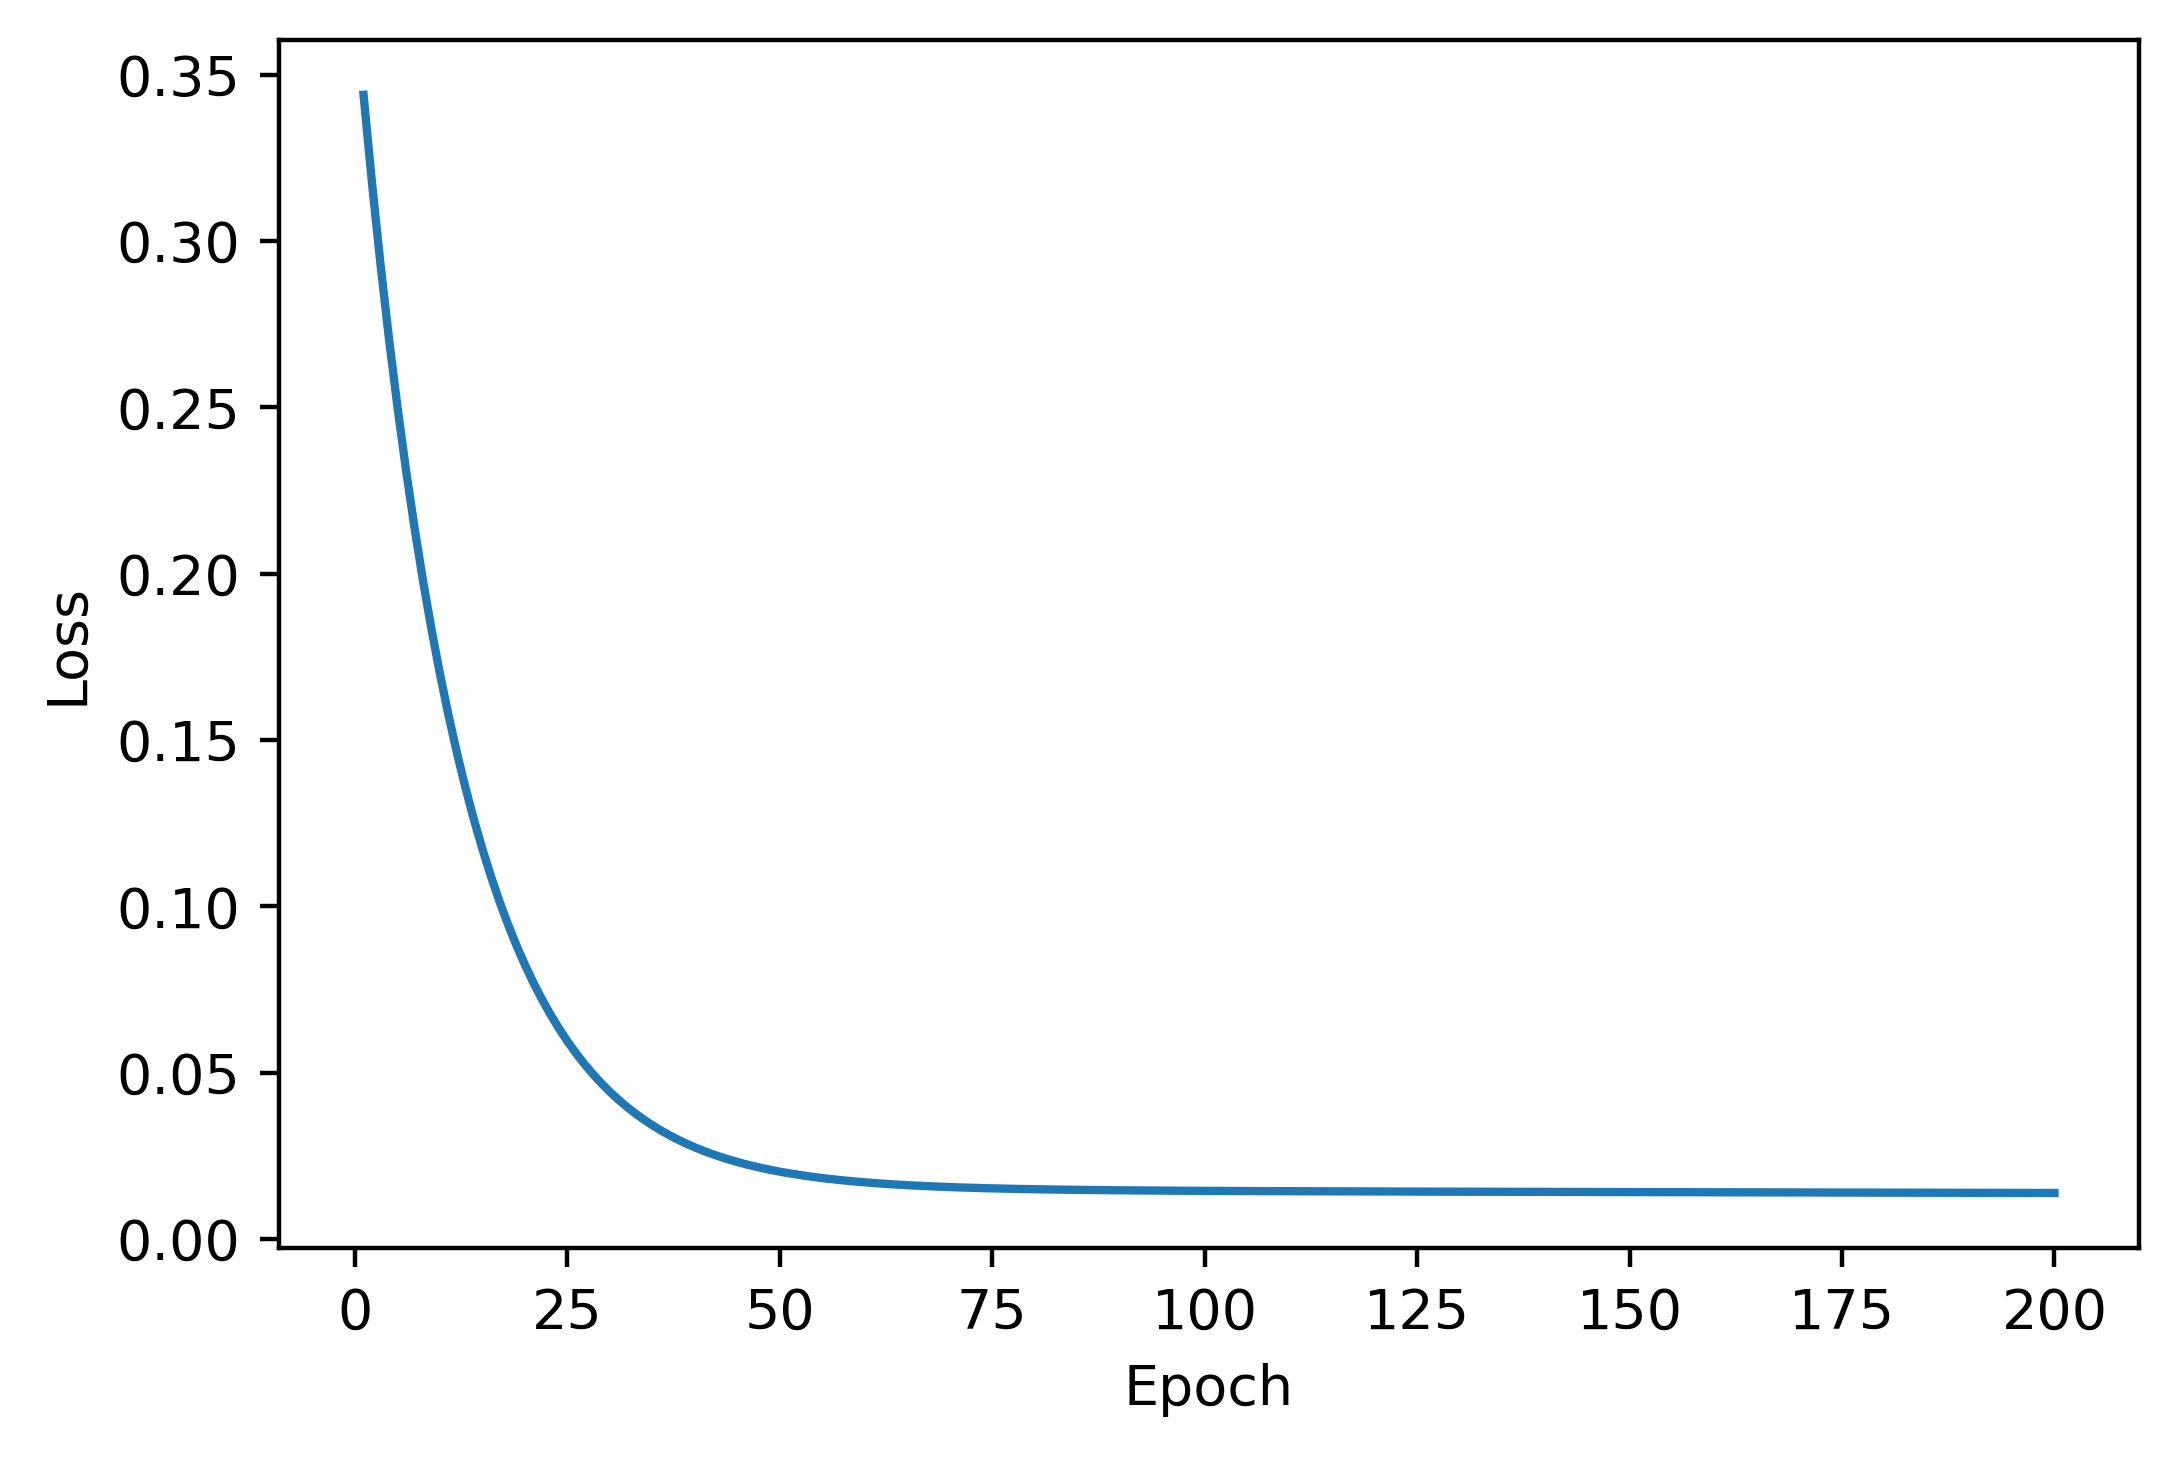

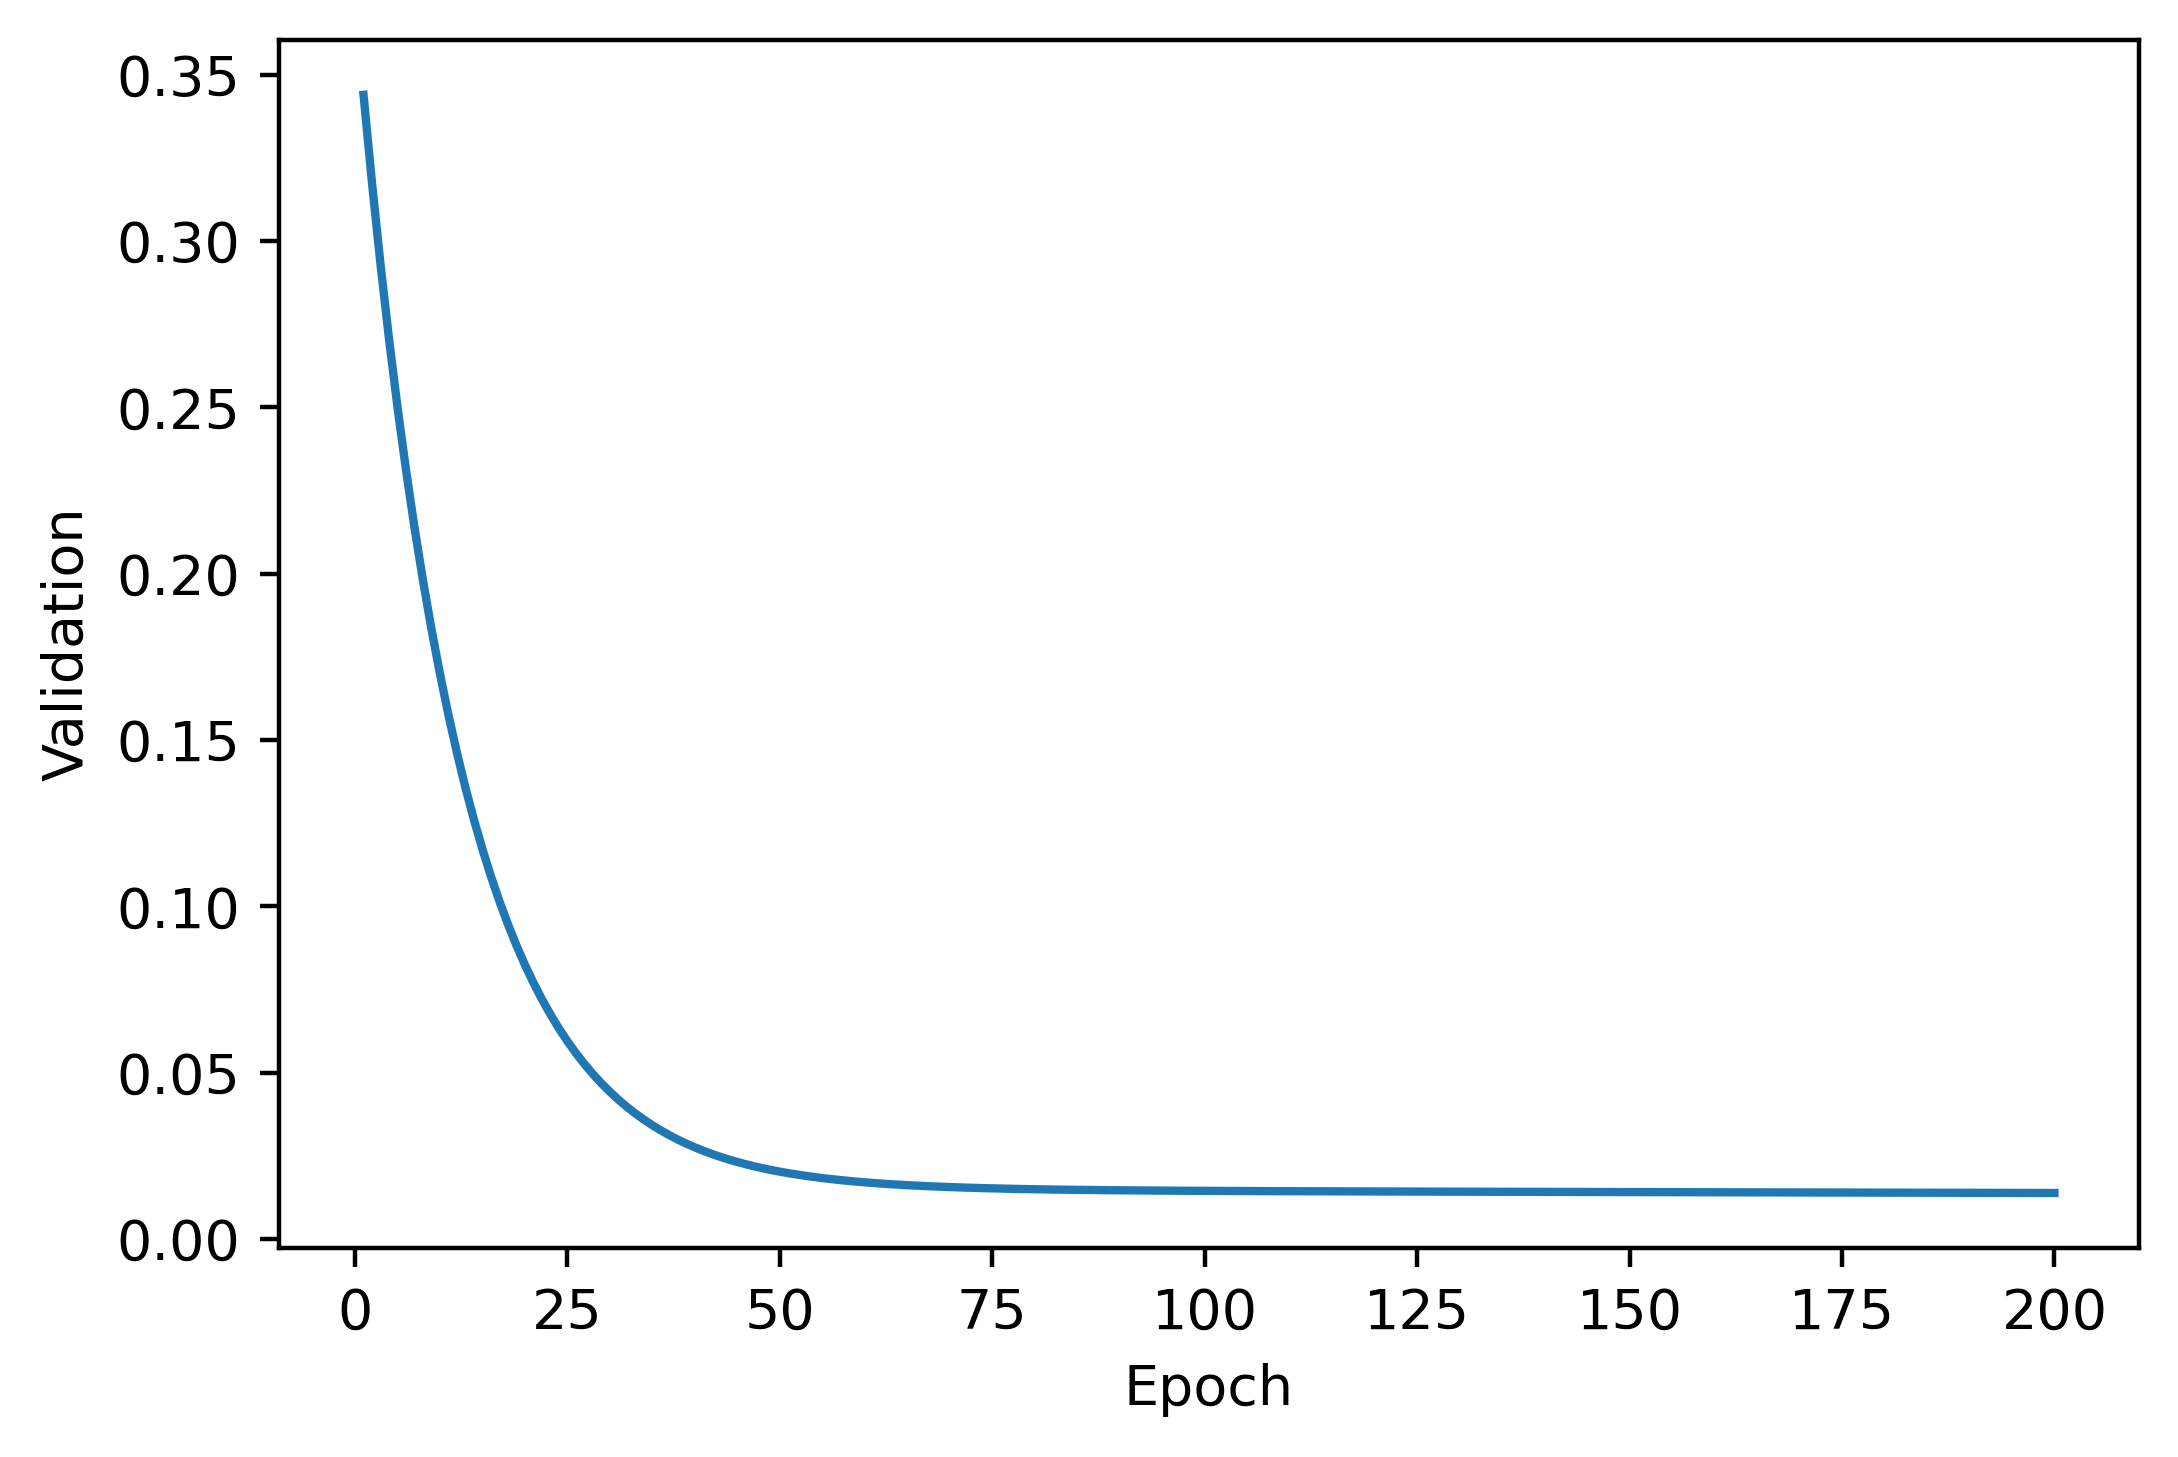

In [9]:
training_loop(
    n_epochs=200,
    optimizer=optimizer,
    model=model,
    loss_fn = nn.MSELoss(),
    t_train_u=t_train_un,
    t_train_x=t_train_xn.unsqueeze(1),
    t_val_u=t_val_un,
    t_val_x=t_val_xn.unsqueeze(1)
)

## Q1.2

Time to train: 0.124773


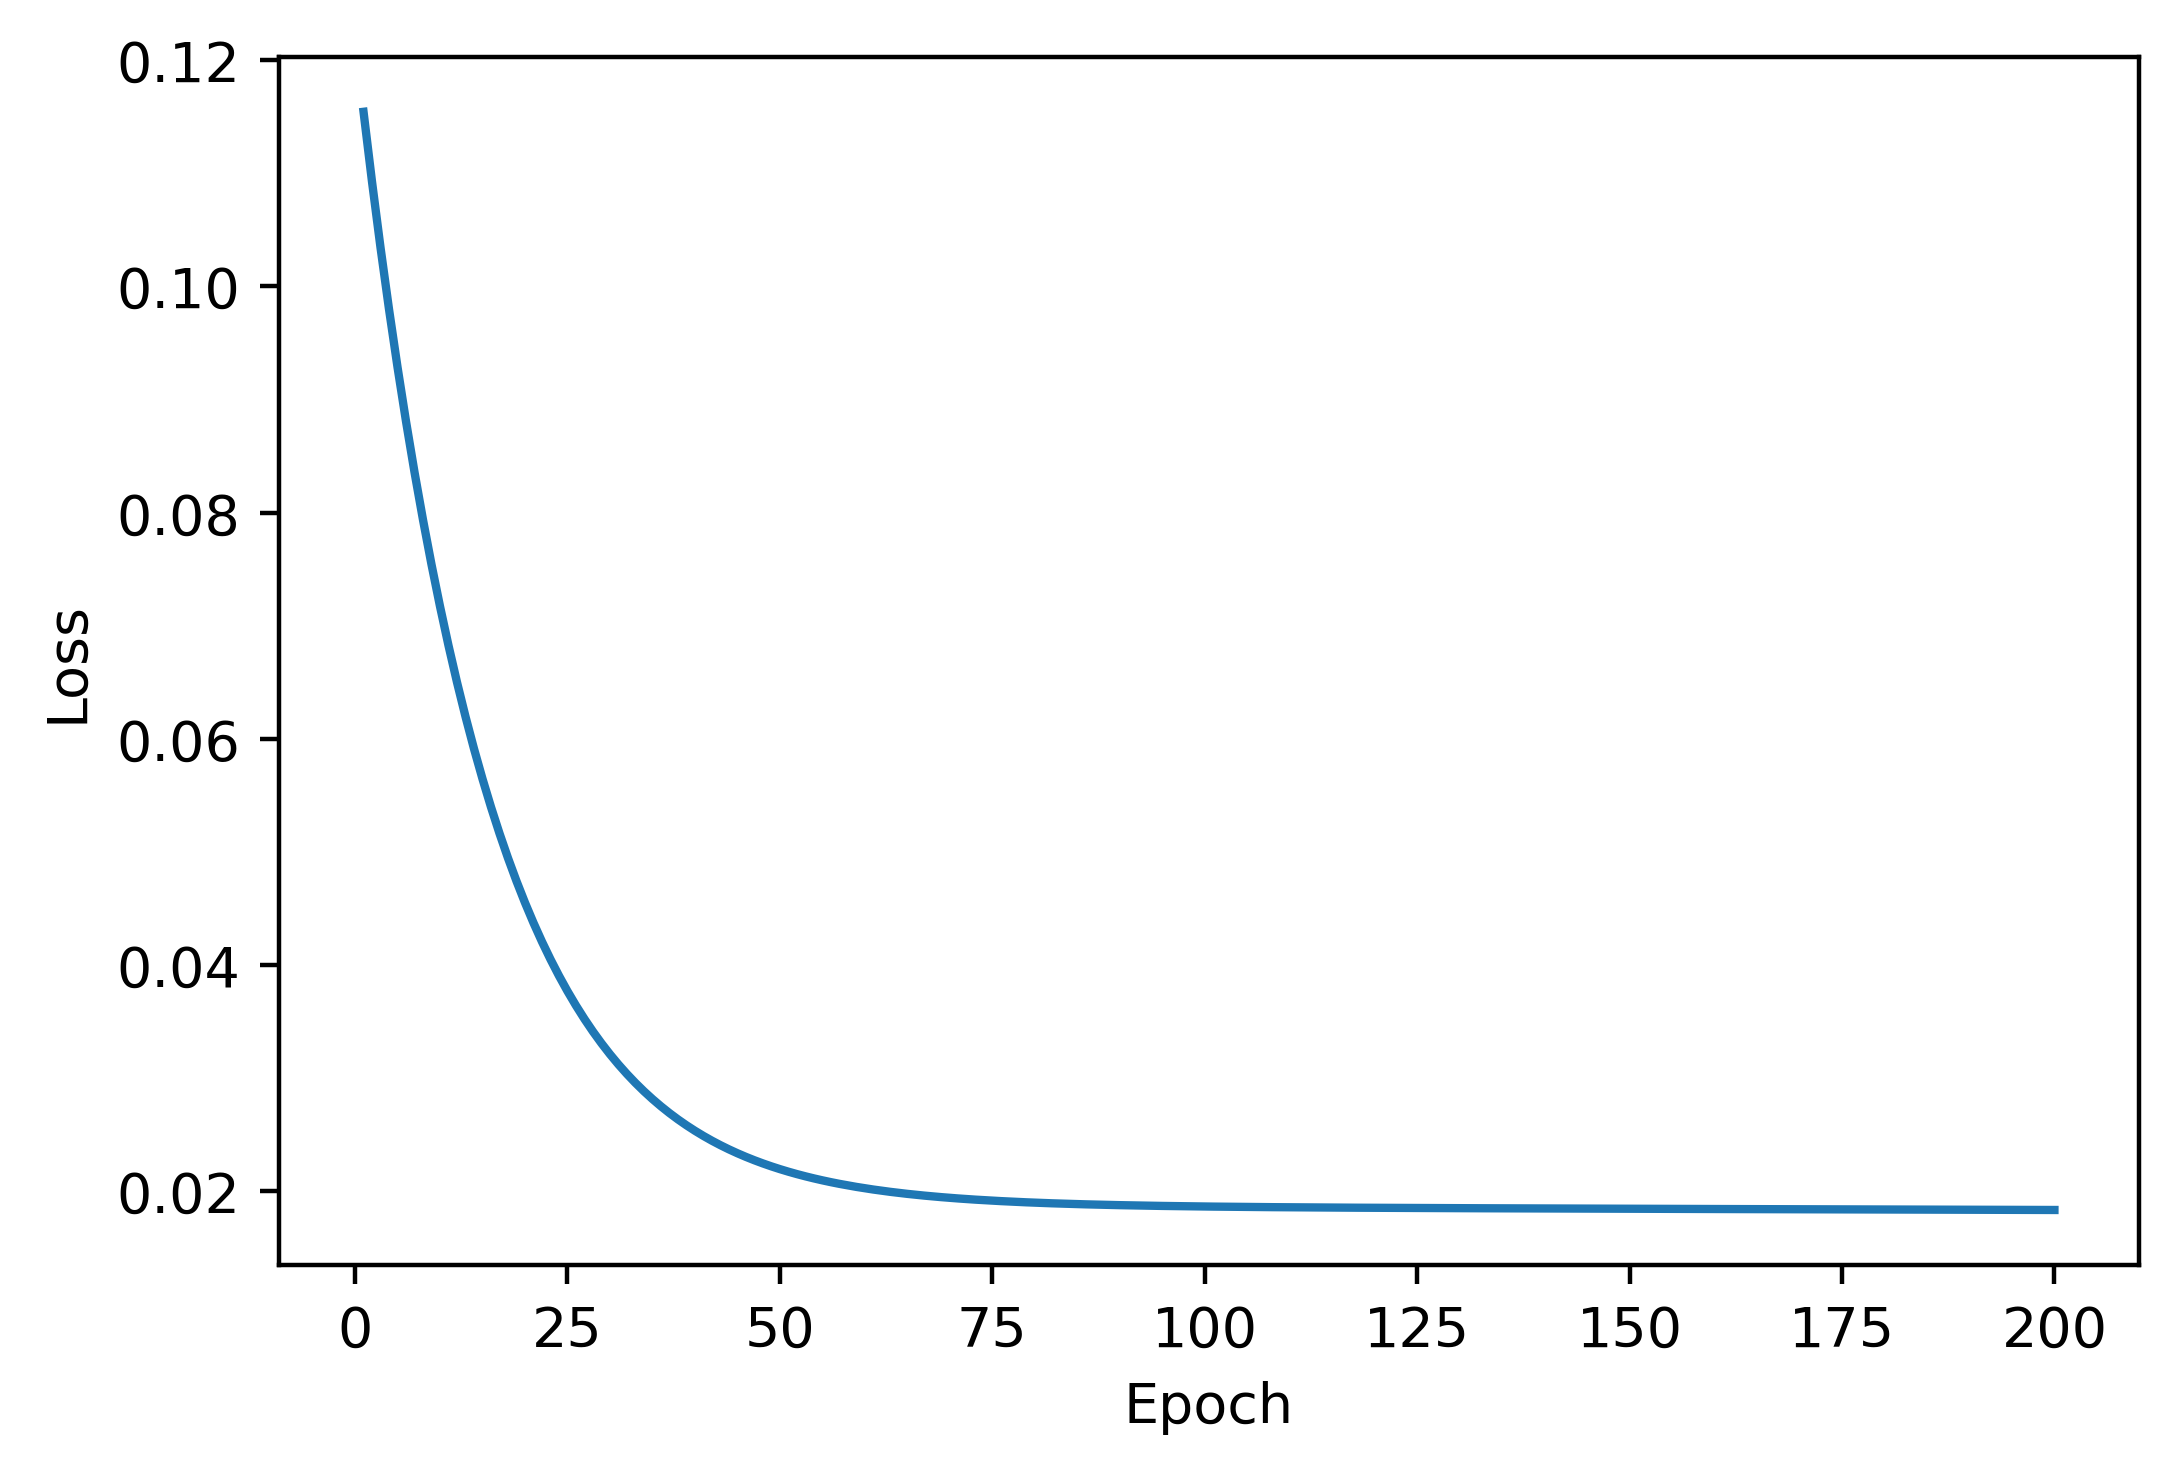

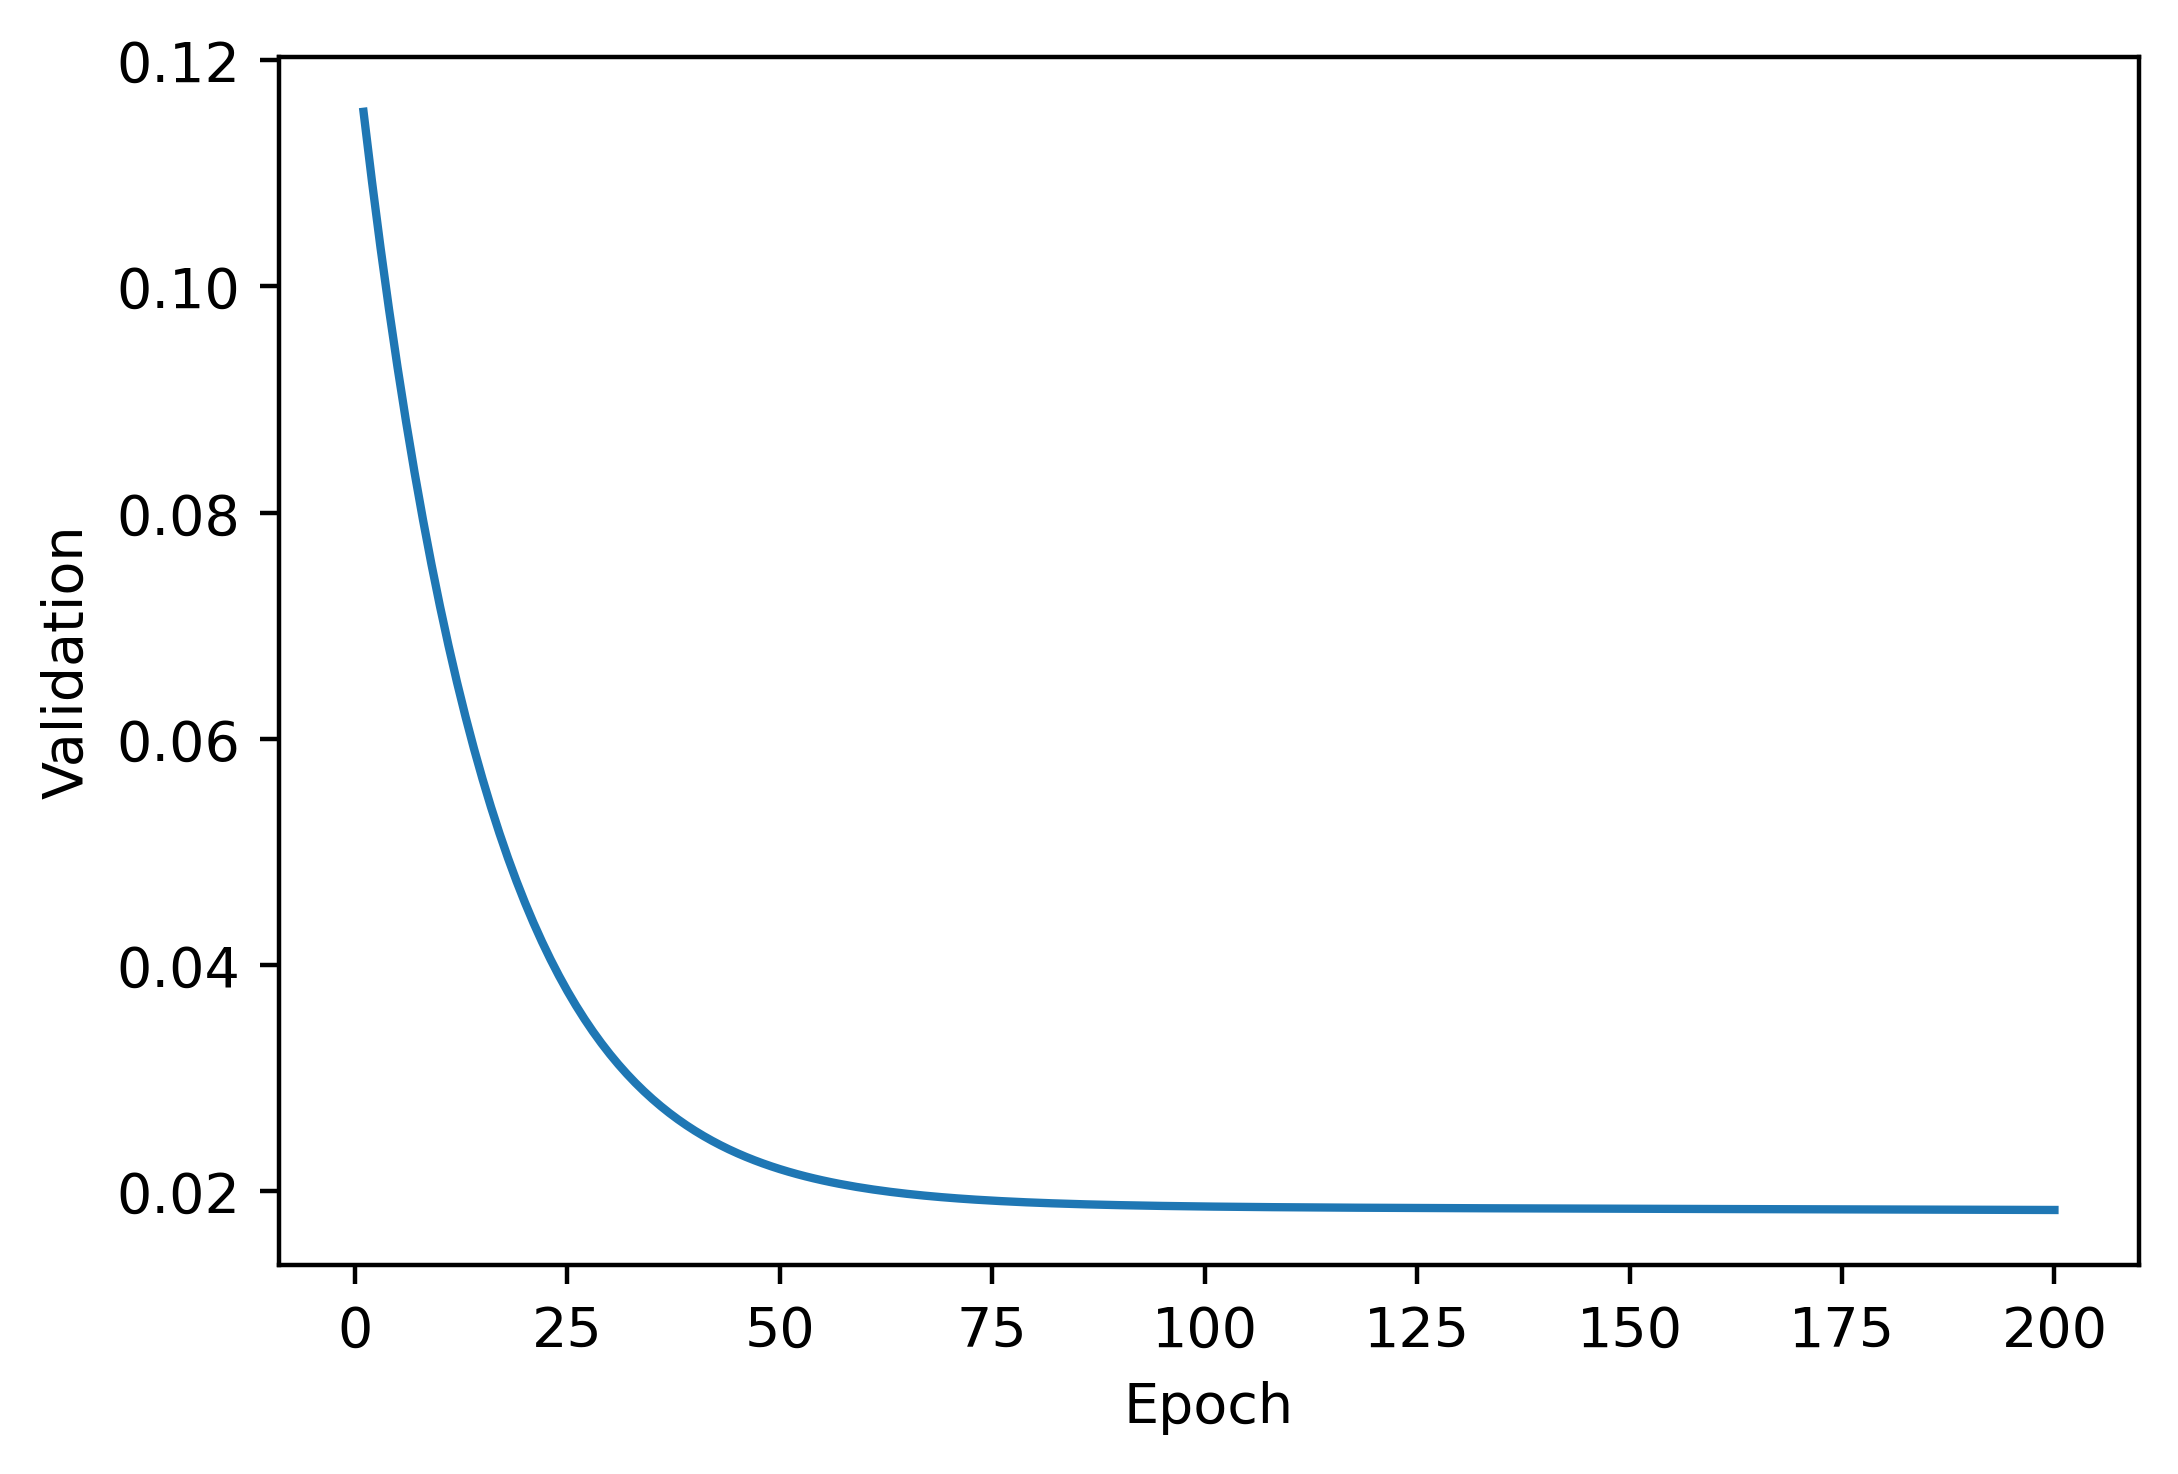

In [10]:
model2 = nn.Sequential(
    nn.Linear(5,8),
    nn.Tanh(),
    nn.Linear(8,6),
    nn.Tanh(),
    nn.Linear(6,3),
    nn.Tanh(),
    nn.Linear(3,1)
)

optimizer2 = optim.SGD(
    model2.parameters(),
    lr=1e-2
)

training_loop(
    n_epochs=200,
    optimizer=optimizer2,
    model=model2,
    loss_fn = nn.MSELoss(),
    t_train_u=t_train_un,
    t_train_x=t_train_xn.unsqueeze(1),
    t_val_u=t_val_un,
    t_val_x=t_val_xn.unsqueeze(1)
)

## Q2.1

In [12]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
data_path = r"C:/Users/Anaconda/UNCC/UNCC/ECGR5106/HW1"
cifar10 = datasets.CIFAR10(data_path, train=True, download=True,transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [13]:
imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
imgs_val = torch.stack([img_t for img_t,_ in cifar10_val], dim=3)

In [14]:
train_mean = imgs.view(3,-1).mean(dim=1)
train_std = imgs.view(3,-1).std(dim=1)
val_mean = imgs_val.view(3,-1).mean(dim=1)
val_std = imgs_val.view(3,-1).std(dim=1)

In [15]:
norm_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean,train_std)
]))
norm_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(val_mean,val_std)
]))

In [16]:
train_loader = torch.utils.data.DataLoader(norm_cifar10, batch_size=1000, shuffle=True)
val_loader = torch.utils.data.DataLoader(norm_cifar10_val, batch_size=1000, shuffle=True)

In [18]:
model3 = nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,10),
    nn.LogSoftmax(dim=1)
).to(device)

learning_rate = 1e-2
optimizer3 = optim.SGD(model3.parameters(),lr=learning_rate)


In [22]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_load, val_load):
    second = time.time()
    t = []
    val = []
    for epoch in range(1, n_epochs + 1):
        count = 0
        correct = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)        
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size,-1))
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                batch_size = imgs.shape[0]
                outputs = model(imgs.view(batch_size,-1))
                _, predicted = torch.max(outputs,dim=1)
                count += labels.shape[0]
                correct += int((predicted==labels).sum())
        
        if epoch % 10 == 0:
            print("Epoch %d, Train Loss: %f, Val Accuracy: %f" % (epoch, float(loss), float(correct/count)))
        t.append(float(loss))
        val.append(float(correct/count))
    print("Time to complete training: %f" % float(time.time()-second))
    fig = plt.figure(dpi=400)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(1,n_epochs+1), t)
    fig2 = plt.figure(dpi=400)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(range(1,n_epochs+1), val)

Epoch 10, Train Loss: 1.725178, Val Accuracy: 0.404300
Epoch 20, Train Loss: 1.652619, Val Accuracy: 0.421900
Epoch 30, Train Loss: 1.632584, Val Accuracy: 0.431000
Epoch 40, Train Loss: 1.581371, Val Accuracy: 0.439800
Epoch 50, Train Loss: 1.565609, Val Accuracy: 0.447600
Epoch 60, Train Loss: 1.561149, Val Accuracy: 0.455100
Epoch 70, Train Loss: 1.525684, Val Accuracy: 0.459000
Epoch 80, Train Loss: 1.488213, Val Accuracy: 0.463400
Epoch 90, Train Loss: 1.379689, Val Accuracy: 0.469800
Epoch 100, Train Loss: 1.409531, Val Accuracy: 0.477300
Epoch 110, Train Loss: 1.366141, Val Accuracy: 0.479000
Epoch 120, Train Loss: 1.388959, Val Accuracy: 0.479300
Epoch 130, Train Loss: 1.295273, Val Accuracy: 0.484500
Epoch 140, Train Loss: 1.279354, Val Accuracy: 0.488900
Epoch 150, Train Loss: 1.239260, Val Accuracy: 0.489300
Epoch 160, Train Loss: 1.254624, Val Accuracy: 0.490600
Epoch 170, Train Loss: 1.228852, Val Accuracy: 0.493200
Epoch 180, Train Loss: 1.163852, Val Accuracy: 0.497100
E

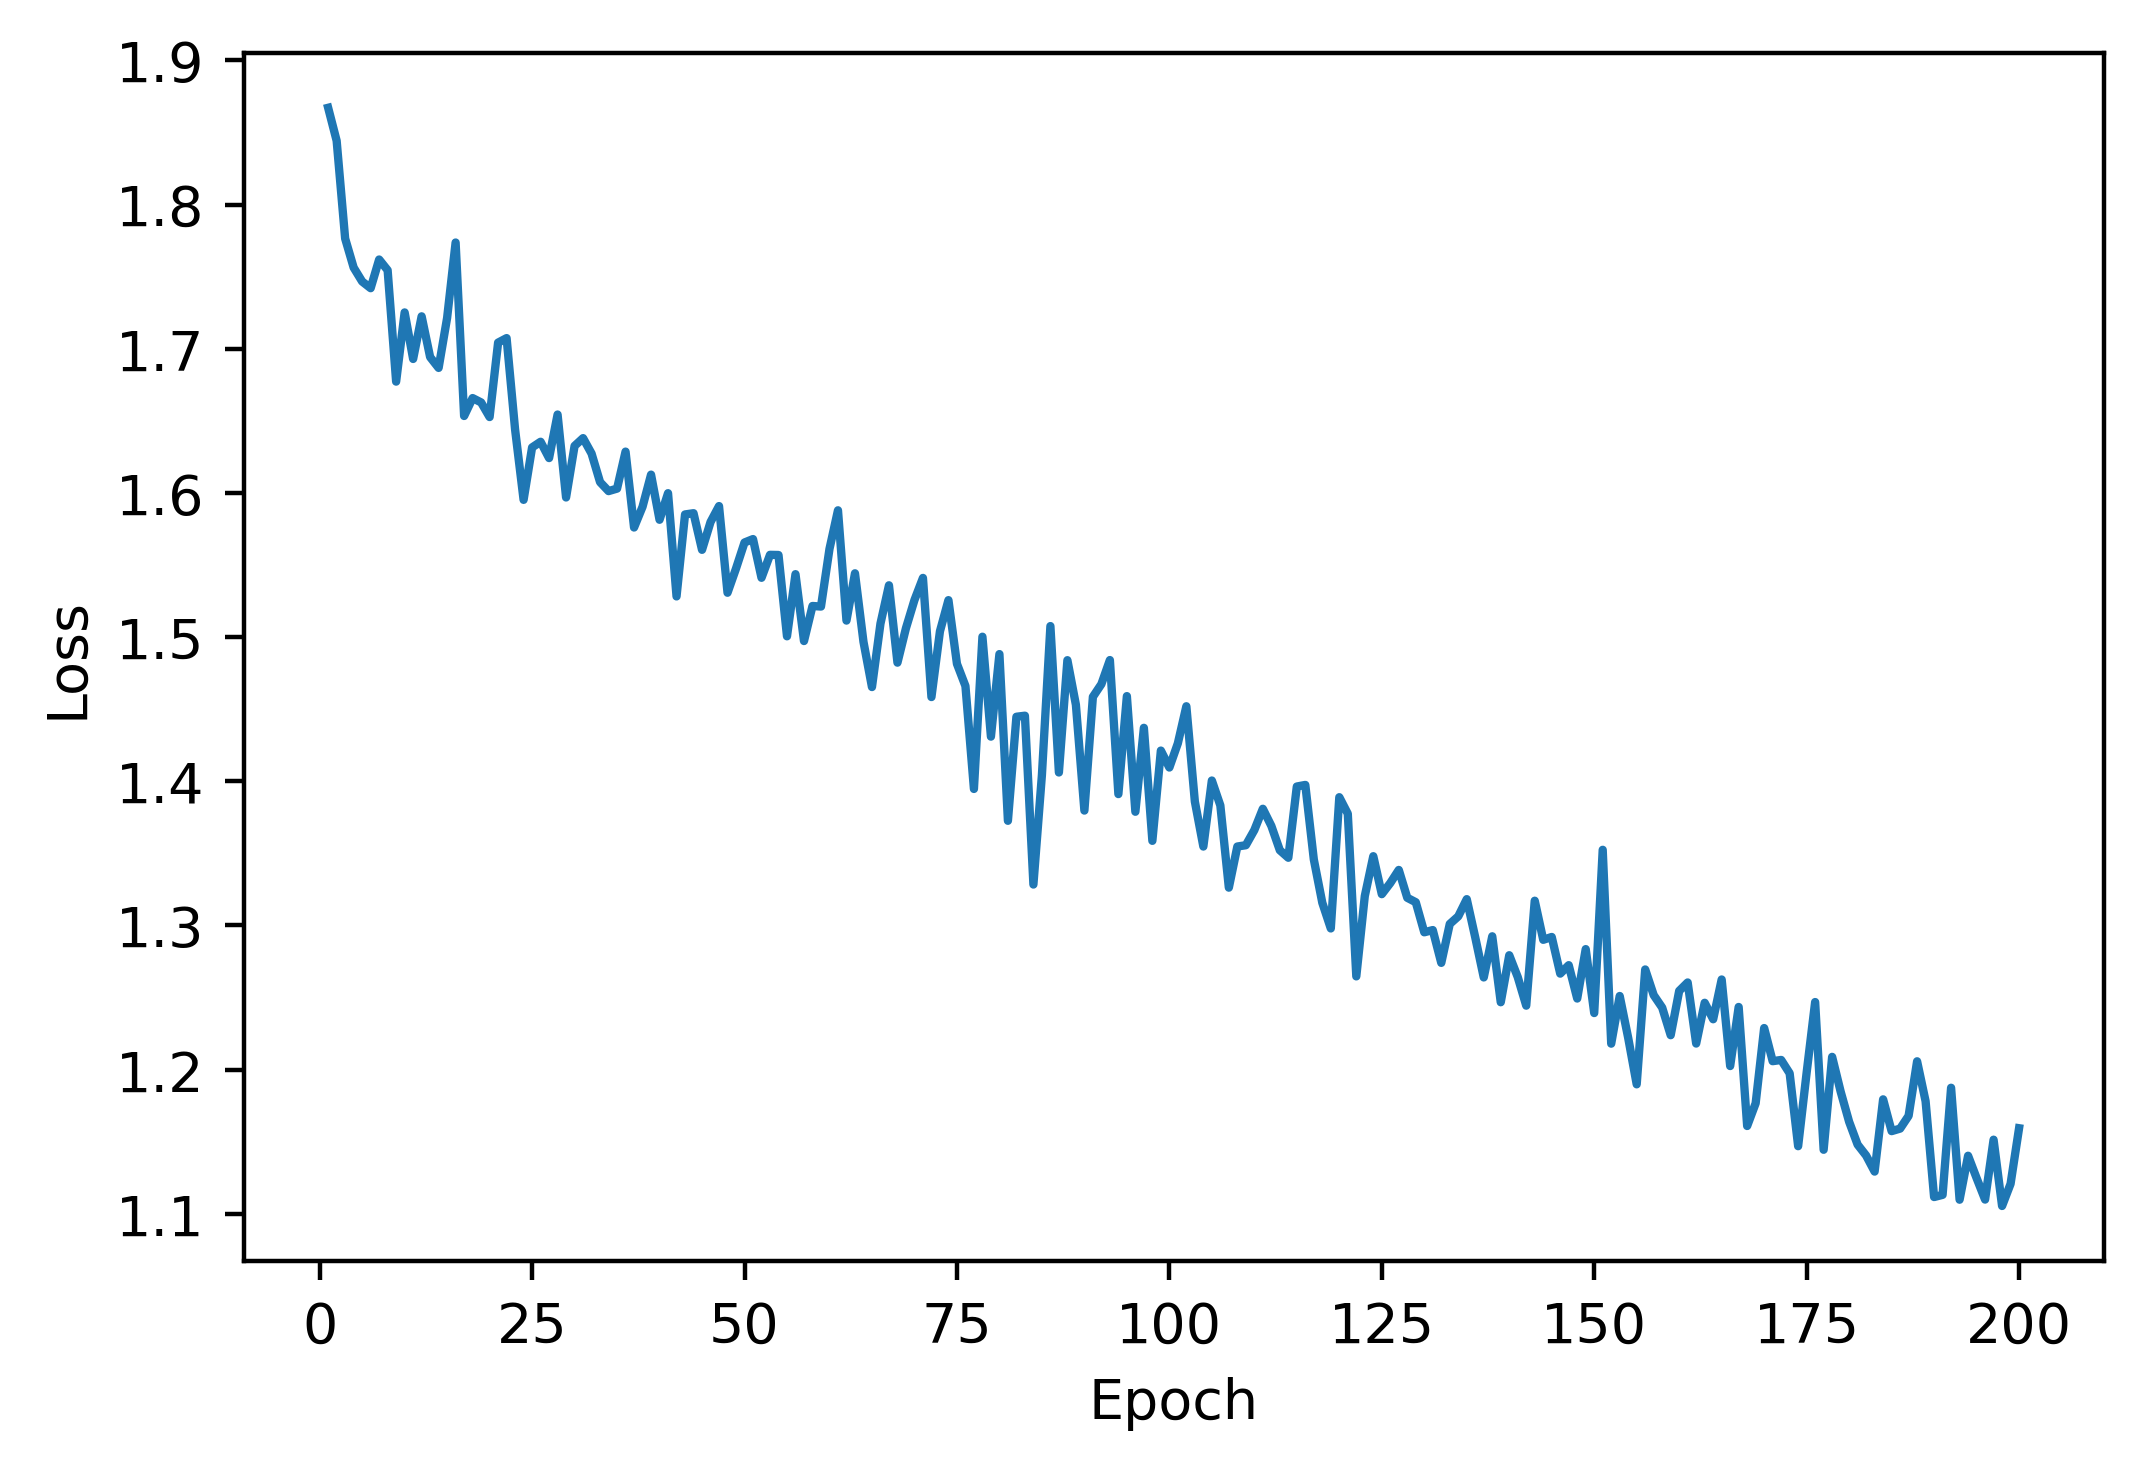

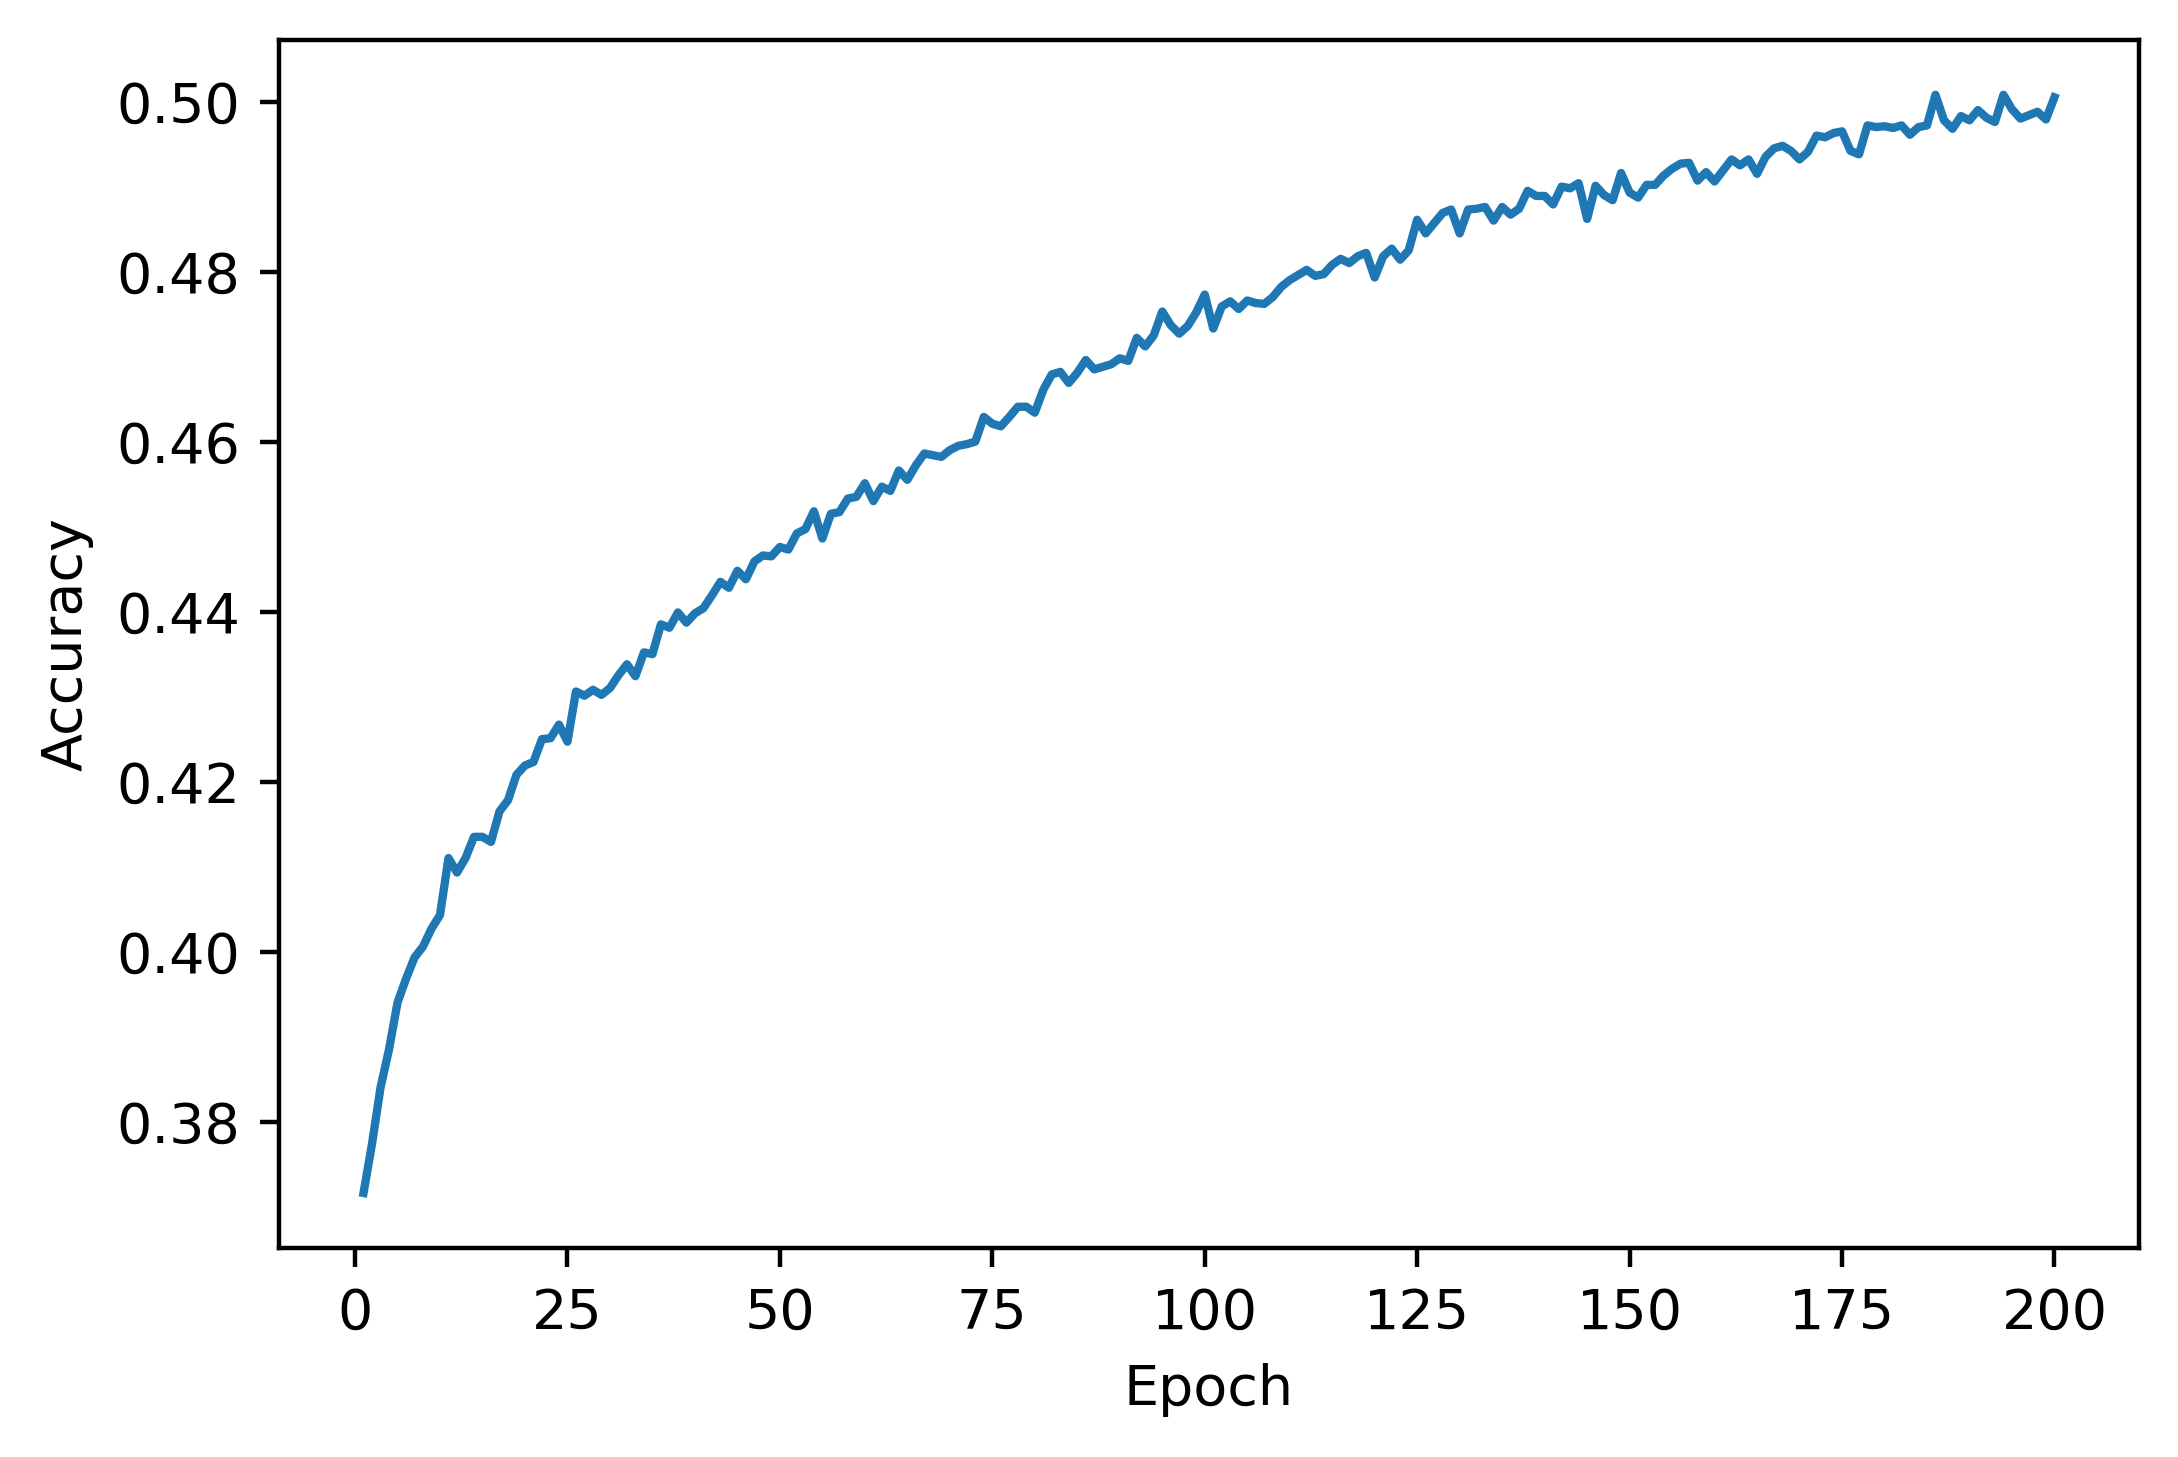

In [23]:

training_loop(
    n_epochs=200, 
    optimizer=optimizer3, 
    model=model3, 
    loss_fn=nn.NLLLoss().to(device), 
    train_load=train_loader, 
    val_load=val_loader
)


## Q2.2

In [24]:
model4 = nn.Sequential(
    nn.Linear(3072,1024),
    nn.Tanh(),
    nn.Linear(1024,512),
    nn.Tanh(),
    nn.Linear(512,256),
    nn.Tanh(),
    nn.Linear(256,10),
    nn.LogSoftmax(dim=1)
).to(device)

learning_rate = 1e-2
optimizer4 = optim.SGD(model4.parameters(),lr=learning_rate)

Epoch 10, Train Loss: 1.811822, Val Accuracy: 0.365800
Epoch 20, Train Loss: 1.695181, Val Accuracy: 0.396500
Epoch 30, Train Loss: 1.678261, Val Accuracy: 0.413200
Epoch 40, Train Loss: 1.639808, Val Accuracy: 0.422000
Epoch 50, Train Loss: 1.636982, Val Accuracy: 0.430400
Epoch 60, Train Loss: 1.570234, Val Accuracy: 0.440500
Epoch 70, Train Loss: 1.521514, Val Accuracy: 0.445200
Epoch 80, Train Loss: 1.492895, Val Accuracy: 0.453300
Epoch 90, Train Loss: 1.466245, Val Accuracy: 0.462200
Epoch 100, Train Loss: 1.422724, Val Accuracy: 0.466600
Epoch 110, Train Loss: 1.370098, Val Accuracy: 0.474000
Epoch 120, Train Loss: 1.339666, Val Accuracy: 0.471700
Epoch 130, Train Loss: 1.275402, Val Accuracy: 0.483200
Epoch 140, Train Loss: 1.291806, Val Accuracy: 0.479100
Epoch 150, Train Loss: 1.325444, Val Accuracy: 0.465000
Epoch 160, Train Loss: 1.249735, Val Accuracy: 0.447200
Epoch 170, Train Loss: 1.025559, Val Accuracy: 0.487400
Epoch 180, Train Loss: 1.063584, Val Accuracy: 0.482600
E

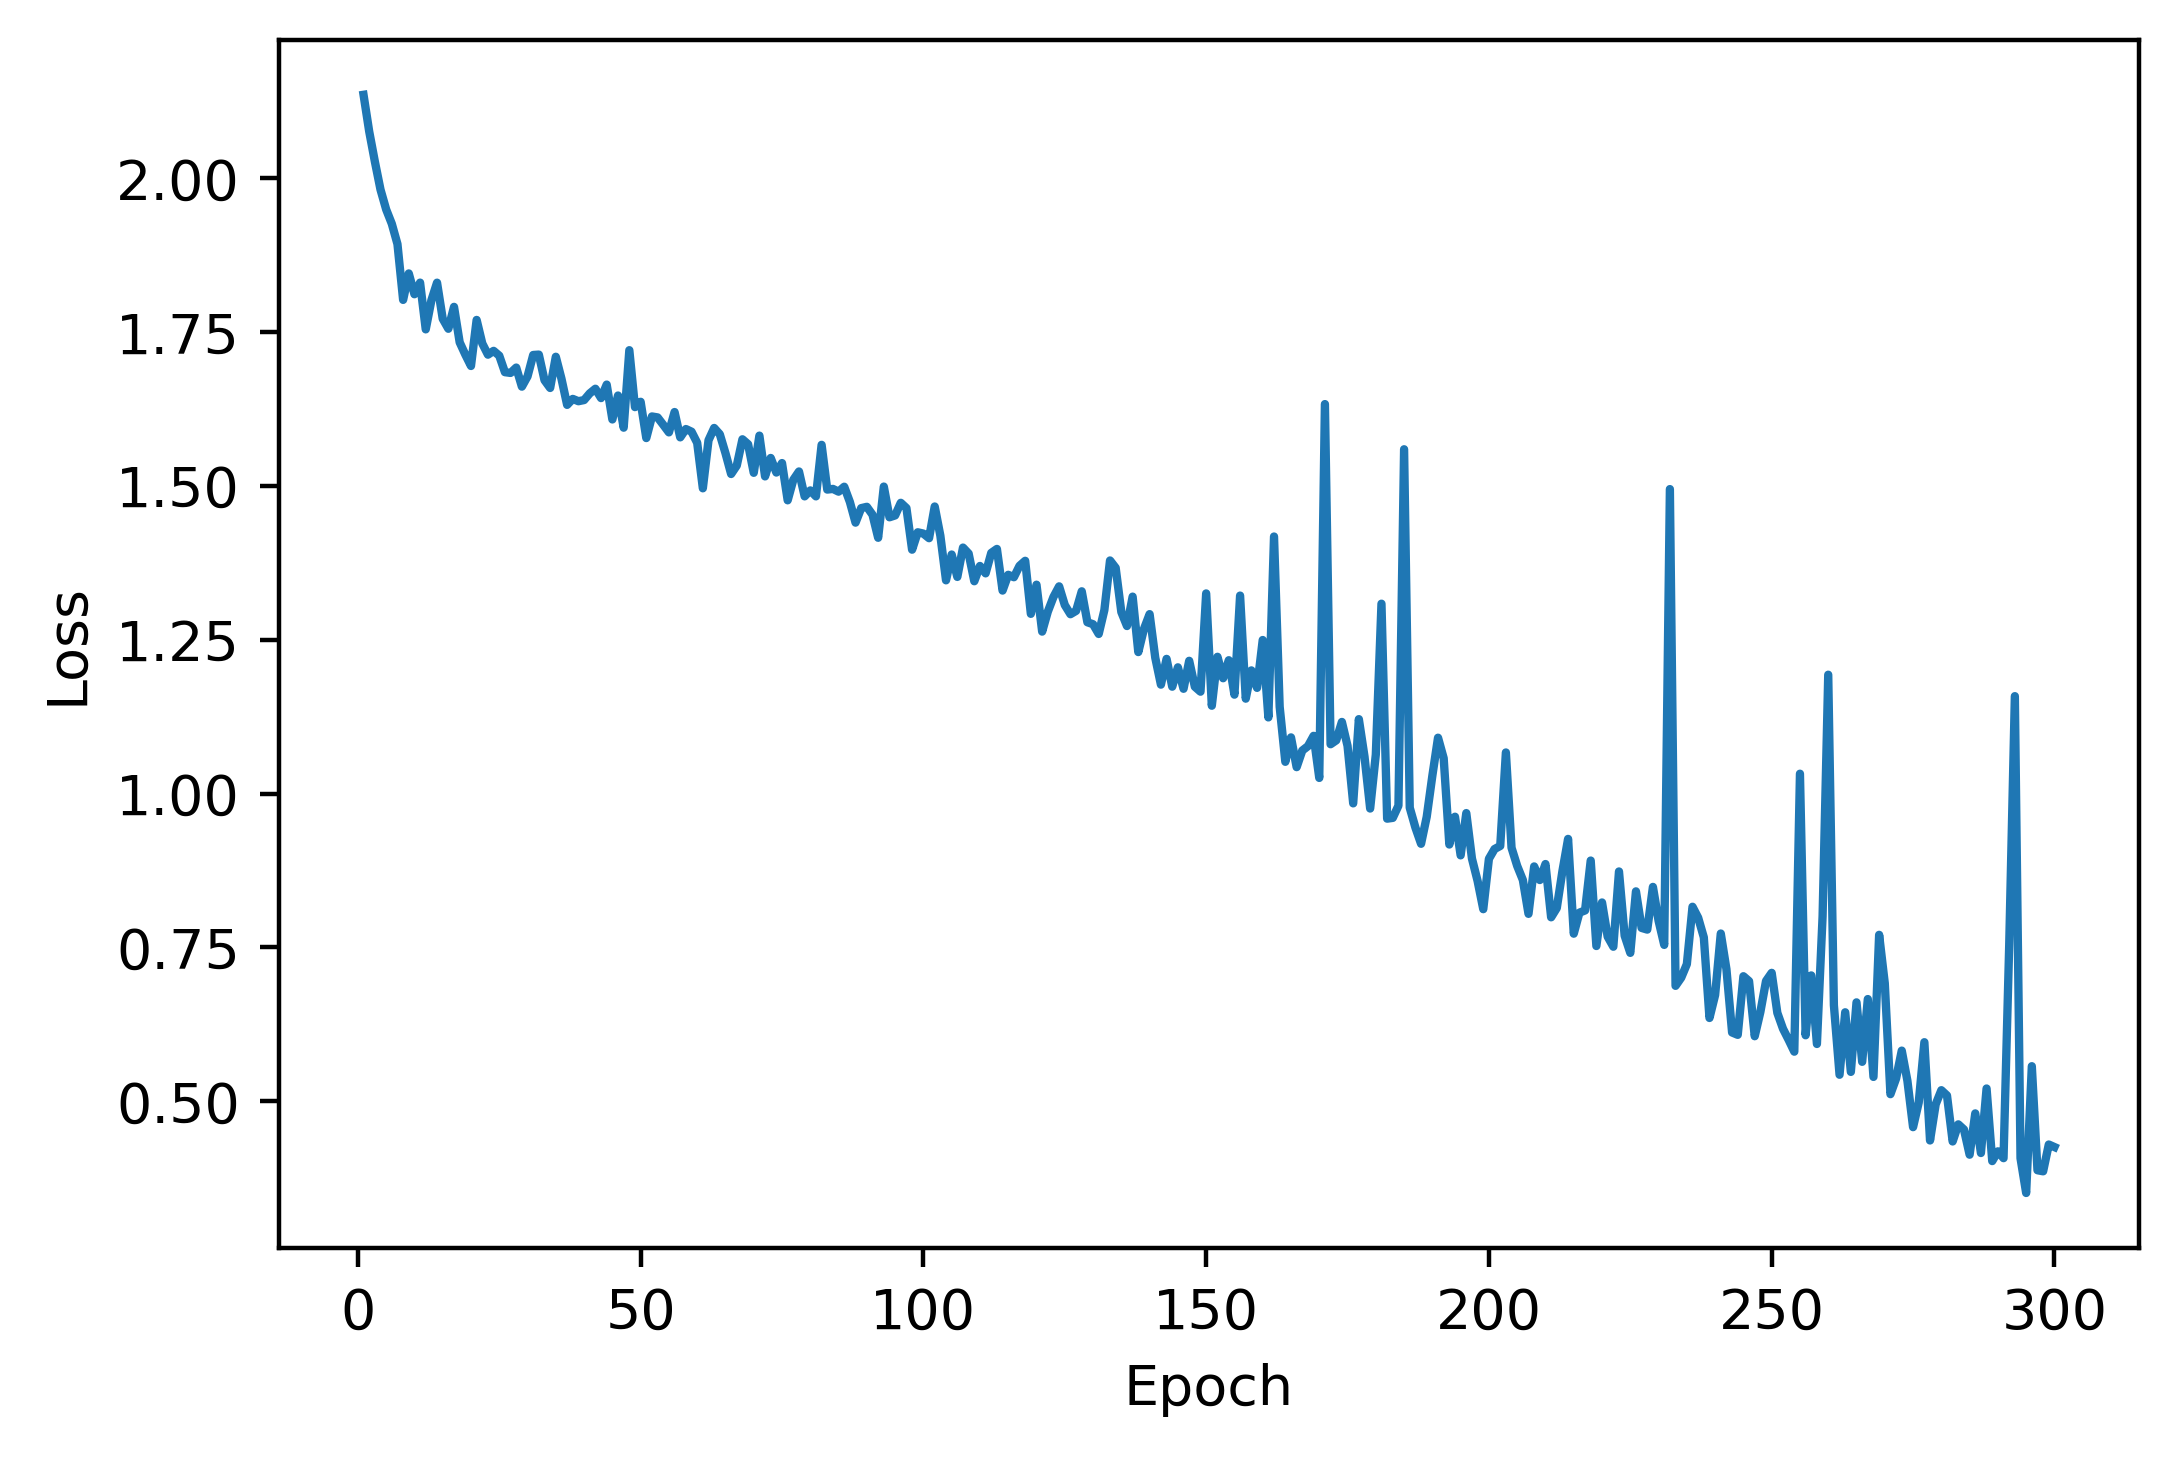

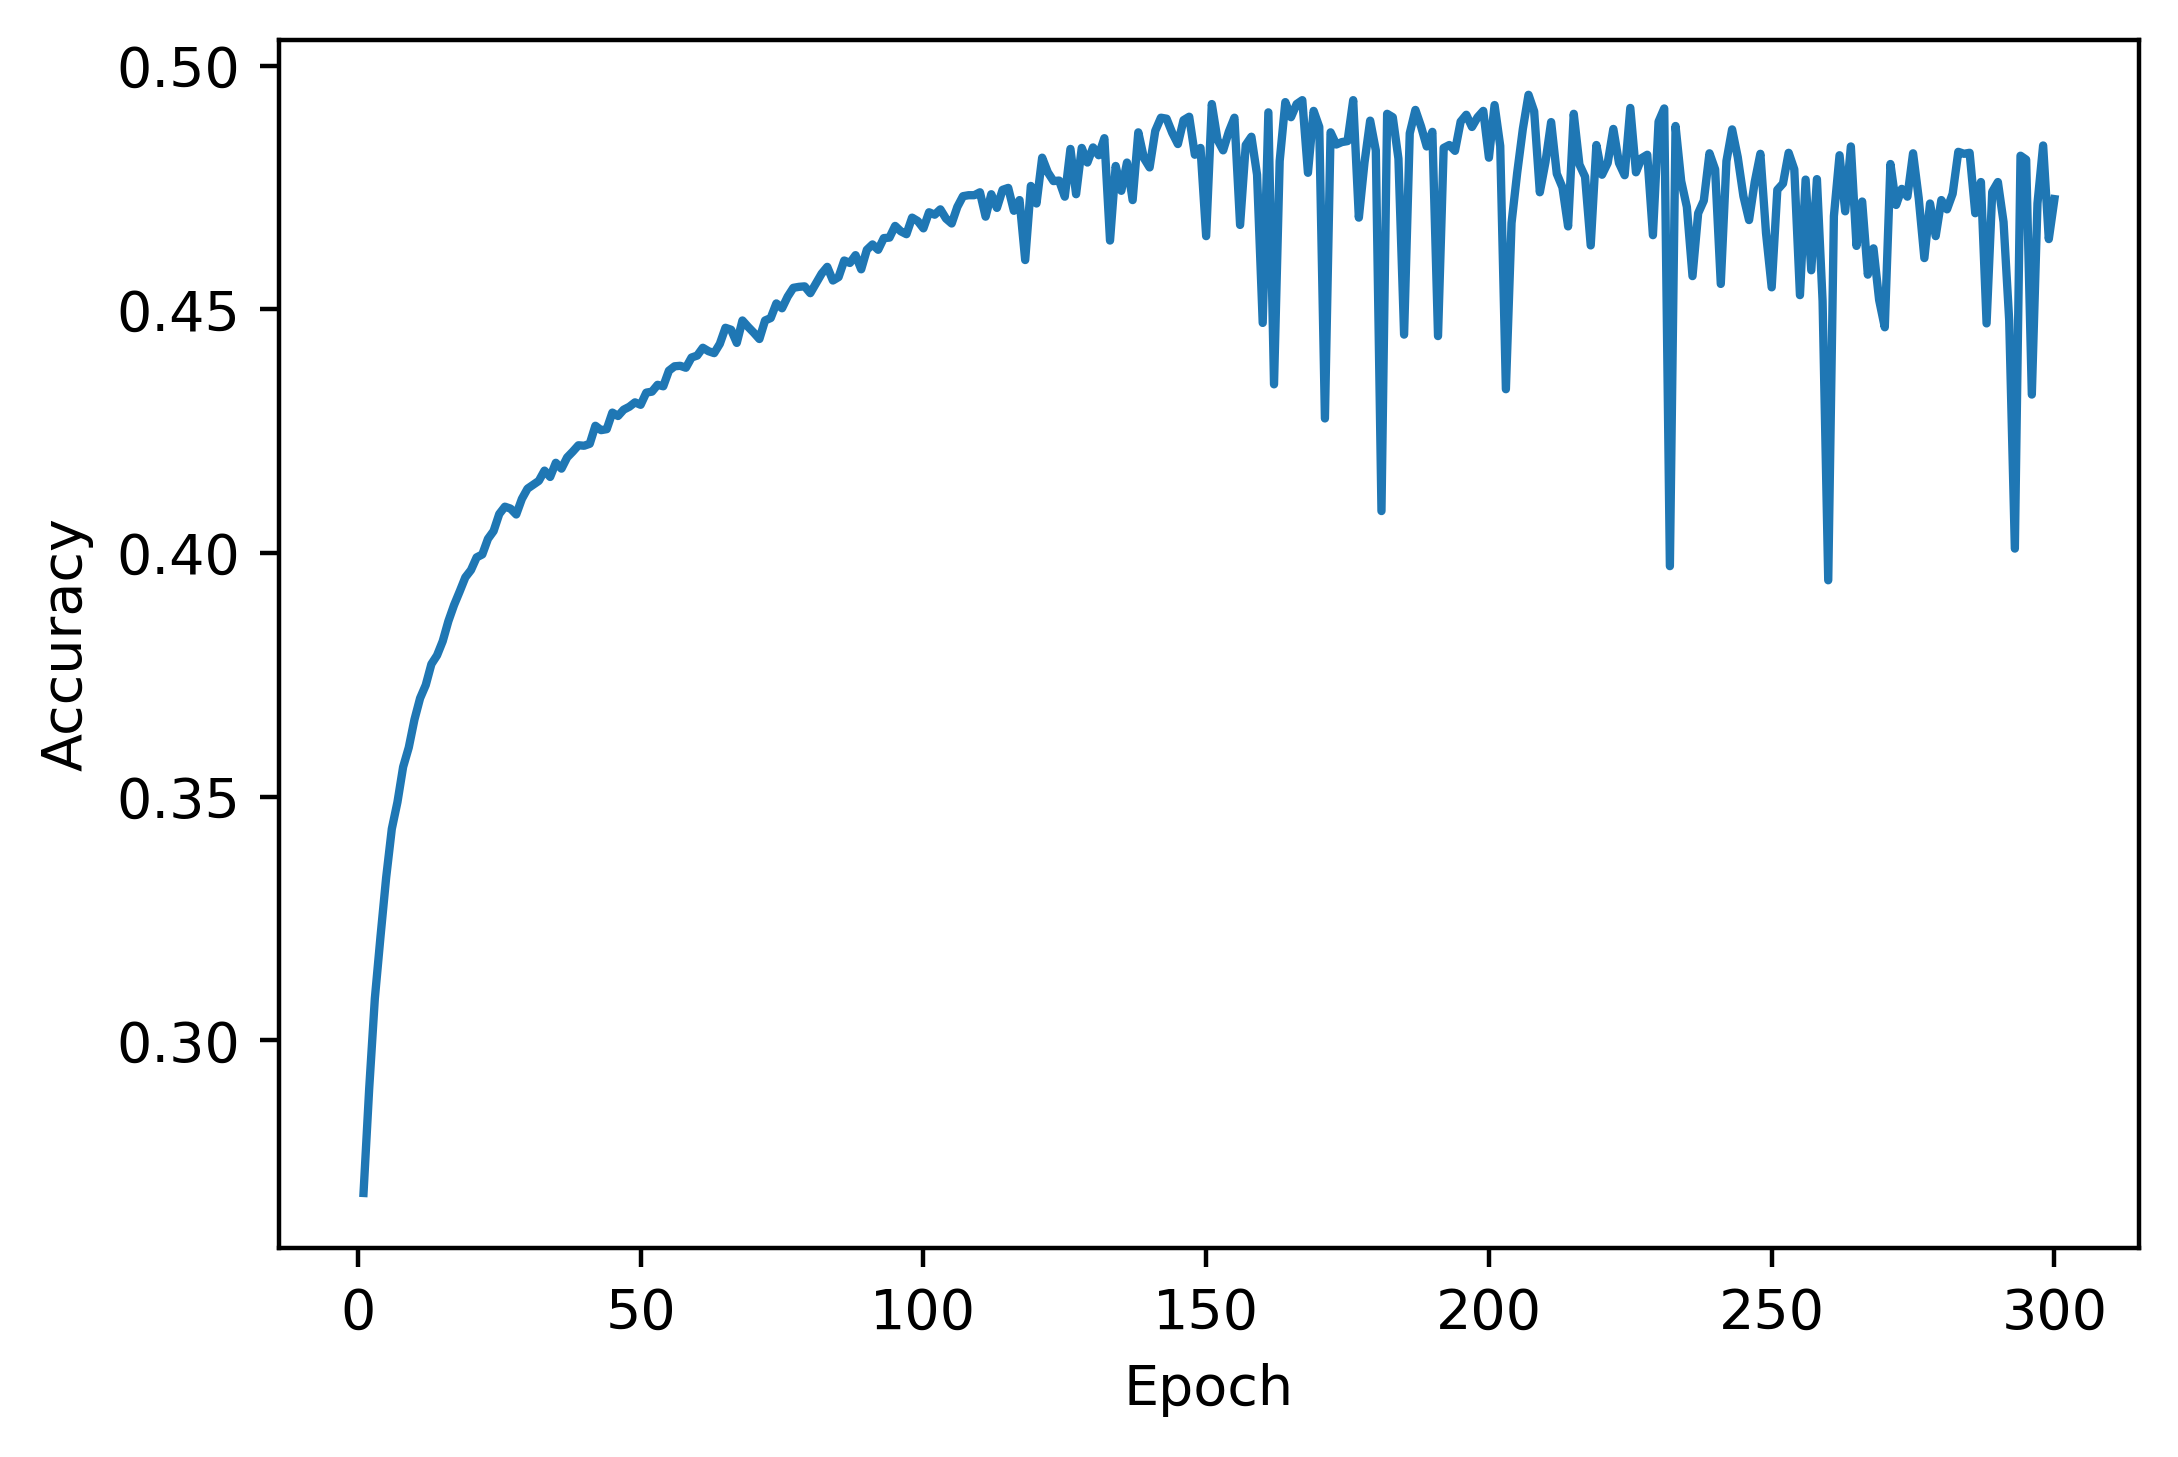

In [25]:
training_loop(
    n_epochs=300, 
    optimizer=optimizer4, 
    model=model4, 
    loss_fn=nn.NLLLoss().to(device), 
    train_load=train_loader, 
    val_load=val_loader
)
